<a href="https://colab.research.google.com/github/TongQM/SONAR_VLM/blob/main/sonar_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install SONAR embeddings and requirements

In [ ]:
!pip show torch

Name: torch
Version: 2.6.0+cu124
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-cusparselt-cu12, nvidia-nccl-cu12, nvidia-nvjitlink-cu12, nvidia-nvtx-cu12, sympy, triton, typing-extensions
Required-by: accelerate, fastai, peft, sentence-transformers, timm, torchaudio, torchvision


In [ ]:
# !pip install fairseq2 --extra-index-url https://fair.pkg.atmeta.com/fairseq2/whl/pt2.6.0/cu124
!pip install sonar-space

  Using cached sonar_space-0.4.0-py3-none-any.whl.metadata (21 kB)
  Using cached sox-1.5.0.tar.gz (63 kB)
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 3.9 MB/s eta 0:00:00
  Created wheel for sox: filename=sox-1.5.0-py3-none-any.whl size=40037 sha256=a7b9da77a43959baf8c13994e2a6e9ff51375a7323929d116431b7d48f7fdb84
  Stored in directory: /root/.cache/pip/wheels/74/89/93/023fcdacaec4e5471e78b43992515e8500cc2505b307e2e6b7
Successfully built sox


# Mount Google drive and set work directory

In [ ]:
import os
from google.colab import drive

drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/sonar')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!ls annotations/

captions_train2017.json  instances_train2017.json  person_keypoints_train2017.json
captions_val2017.json	 instances_val2017.json    person_keypoints_val2017.json


# Load train and validation data

In [ ]:
import json

train_data = json.load(open("./annotations/captions_train2017.json"))
val_data = json.load(open("./annotations/captions_val2017.json"))
print(f"There are {len(train_data['images'])} pictures in training data.")
print(f"There are {len(val_data['images'])} pictures in validation data.")

There are 118287 pictures in training data.
There are 5000 pictures in validation data.


## Load text2embedding model

In [ ]:
from sonar.inference_pipelines.text import TextToEmbeddingModelPipeline
import torch

t2vec_model = TextToEmbeddingModelPipeline(encoder="text_sonar_basic_encoder",
                                           tokenizer="text_sonar_basic_encoder",
                                           device=torch.device("cuda"),
                                           dtype=torch.float16)
sentences = ["Today is a good day, tomorrow is a rainy day.", "Can we finish the paper on time?"]
embeddings = t2vec_model.predict(sentences, source_lang="eng_Latn")
print(embeddings.shape)

torch.Size([2, 1024])


In [ ]:
sentence = ["My name is Yidi Miao"]
embedding = t2vec_model.predict(sentence, source_lang="eng_Latn")
print(embedding.shape)

torch.Size([1, 1024])


In [ ]:
from sonar.inference_pipelines.text import EmbeddingToTextModelPipeline
vec2text_model = EmbeddingToTextModelPipeline(decoder="text_sonar_basic_decoder",
                                              tokenizer="text_sonar_basic_encoder")
reconstructed = vec2text_model.predict(embedding, target_lang="eng_Latn", max_seq_len=512)
# max_seq_len is a keyword argument passed to the fairseq2 BeamSearchSeq2SeqGenerator.
print(reconstructed)

100%|██████████| 4.21G/4.21G [02:54<00:00, 25.9MB/s]


['My name is Yidi Miao']


## Visualize 5 images and their captions

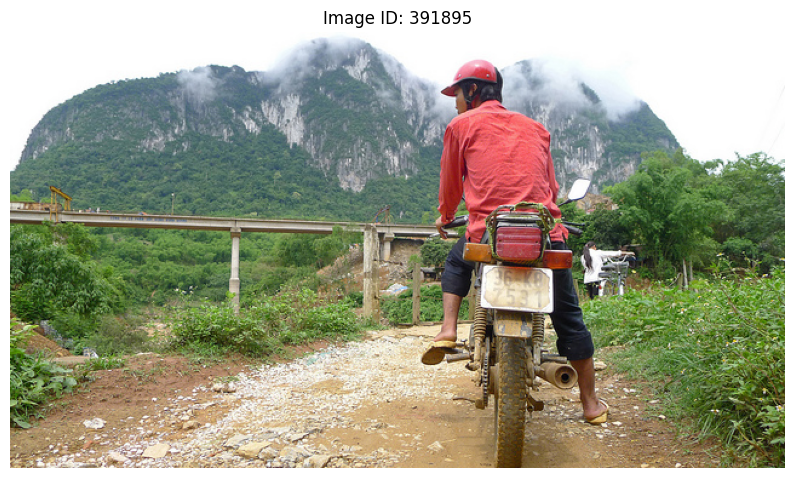

Caption 1: A man with a red helmet on a small moped on a dirt road. 
Embedding 1: tensor([ 0.0023,  0.0024, -0.0058,  ..., -0.0055,  0.0065, -0.0043])
--------------------
Caption 2: Man riding a motor bike on a dirt road on the countryside.
Embedding 2: tensor([-0.0010, -0.0089, -0.0063,  ...,  0.0010,  0.0043,  0.0052])
--------------------
Caption 3: A man riding on the back of a motorcycle.
Embedding 3: tensor([ 0.0044, -0.0020, -0.0043,  ..., -0.0046,  0.0046,  0.0019])
--------------------
Caption 4: A dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud-wreathed mountains. 
Embedding 4: tensor([ 0.0169,  0.0012,  0.0004,  ...,  0.0010,  0.0100, -0.0081])
--------------------
Caption 5: A man in a red shirt and a red hat is on a motorcycle on a hill side.
Embedding 5: tensor([-3.7083e-05, -8.3608e-03,  1.0259e-02,  ...,  1.4428e-03,
         6.7652e-03, -5.0783e-03])
--------------------


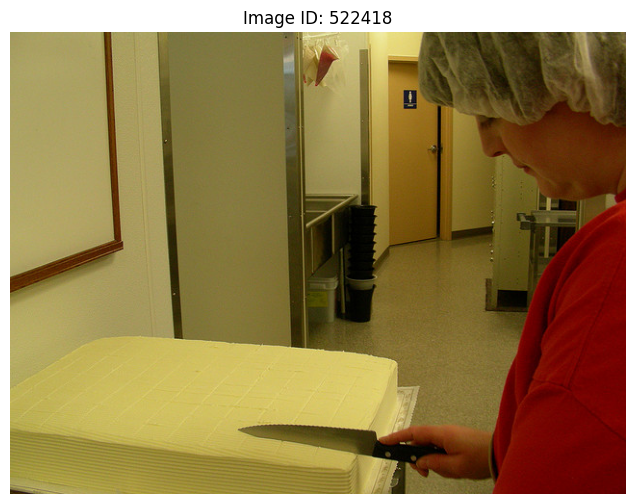

Caption 1: A woman wearing a net on her head cutting a cake. 
Embedding 1: tensor([-0.0059,  0.0068, -0.0051,  ..., -0.0084,  0.0149,  0.0043])
--------------------
Caption 2: A woman cutting a large white sheet cake.
Embedding 2: tensor([-0.0095,  0.0125, -0.0016,  ..., -0.0118,  0.0131, -0.0068])
--------------------
Caption 3: A woman wearing a hair net cutting a large sheet cake.
Embedding 3: tensor([-0.0079,  0.0048, -0.0049,  ..., -0.0132,  0.0167, -0.0016])
--------------------
Caption 4: there is a woman that is cutting a white cake
Embedding 4: tensor([ 0.0013,  0.0067,  0.0004,  ..., -0.0050,  0.0095, -0.0133])
--------------------
Caption 5: A woman marking a cake with the back of a chef's knife. 
Embedding 5: tensor([-0.0081,  0.0017, -0.0036,  ..., -0.0112,  0.0159, -0.0096])
--------------------


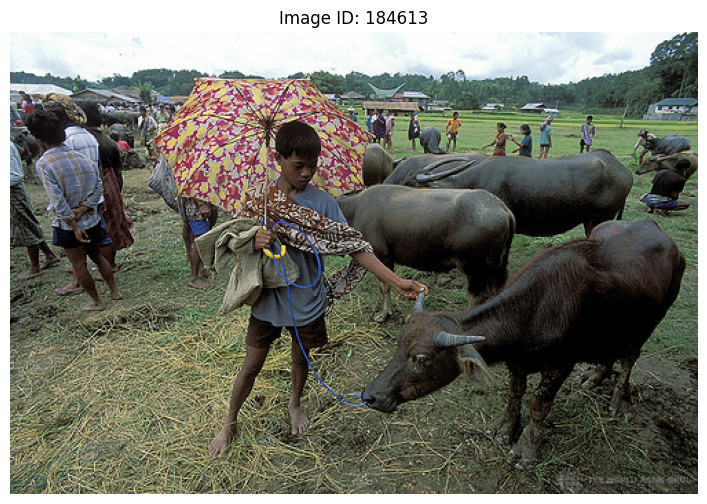

Caption 1: A child holding a flowered umbrella and petting a yak.
Embedding 1: tensor([ 0.0018, -0.0019,  0.0058,  ..., -0.0205,  0.0062, -0.0055])
--------------------
Caption 2: A young man holding an umbrella next to a herd of cattle.
Embedding 2: tensor([-0.0009,  0.0024, -0.0009,  ..., -0.0116,  0.0150, -0.0021])
--------------------
Caption 3: a young boy barefoot holding an umbrella touching the horn of a cow
Embedding 3: tensor([-0.0011, -0.0055,  0.0061,  ..., -0.0052,  0.0053, -0.0103])
--------------------
Caption 4: A young boy with an umbrella who is touching the horn of a cow.
Embedding 4: tensor([-0.0077, -0.0005,  0.0039,  ..., -0.0135,  0.0055, -0.0071])
--------------------
Caption 5: A boy holding an umbrella while standing next to livestock.
Embedding 5: tensor([-0.0002,  0.0007,  0.0075,  ..., -0.0130,  0.0166, -0.0031])
--------------------


In [ ]:
# prompt: Visualize 5 images and their captions

import json
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

# Select 20 images
num_images = 3
images = train_data['images'][:num_images]

for image_info in images:
    image_id = image_info['id']
    image_url = image_info['coco_url']

    # Fetch the image
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content))

    # Find captions for the current image
    captions = [ann['caption'] for ann in train_data['annotations'] if ann['image_id'] == image_id]
    captions = captions[:5] # get first 5 captions

    # Generate embeddings
    embeddings = t2vec_model.predict(captions, source_lang="eng_Latn")

    # Display image and captions with embeddings
    plt.figure(figsize=(10, 6))
    plt.imshow(image)
    plt.title(f"Image ID: {image_id}")
    plt.axis('off')
    plt.show()

    for i, caption in enumerate(captions):
        print(f"Caption {i+1}: {caption}")
        print(f"Embedding {i+1}: {embeddings[i]}")
        print("-" * 20)



# Create a new json file containing embeddings for all captions

In [ ]:
json_train_data = train_data.copy()
json_val_data = val_data.copy()
len(train_data['annotations']), len(val_data['annotations'])

(591753, 25014)

In [ ]:
import torch

# Sort the annotation list in json_train_data and json_val_data
json_train_data['annotations'].sort(key=lambda x: x['id'])
json_val_data['annotations'].sort(key=lambda x: x['id'])

# Get the caption list from json_train_data and json_val_data
train_captions = [ann['caption'] for ann in json_train_data['annotations']]
val_captions = [ann['caption'] for ann in json_val_data['annotations']]

# Get the embeddings of captions and compile embeddings into a list sorted by the id
t2vec_model = TextToEmbeddingModelPipeline(encoder="text_sonar_basic_encoder",
                                           tokenizer="text_sonar_basic_encoder",
                                           device=torch.device("cuda"),
                                           dtype=torch.float16)

train_embeddings = t2vec_model.predict(train_captions, source_lang="eng_Latn")
val_embeddings = t2vec_model.predict(val_captions, source_lang="eng_Latn")

In [ ]:
# Add key: value pair in each dict in annotation with key as 'embedding', and value as the embedding vector for each caption
for i, annotation in enumerate(json_train_data['annotations']):
    annotation['embedding'] = train_embeddings[i].tolist()

for i, annotation in enumerate(json_val_data['annotations']):
    annotation['embedding'] = val_embeddings[i].tolist()

In [ ]:
# Save the updated JSON to a new file
with open('captions_train2017_with_embeddings.json', 'w') as f:
    json.dump(json_train_data, f, indent=2)

with open('captions_val2017_with_embeddings.json', 'w') as f:
    json.dump(json_val_data, f, indent=2)

In [ ]:
!ls

annotations		      captions_val2017_with_embeddings.json  sonar_embedding.ipynb
annotations_trainval2017.zip  Project_VL_Frameworks.ipynb


In [ ]:
!rm captions_train2017_with_embeddings.json

In [ ]:
with open('captions_train2017_with_embeddings.json', 'w') as f:
    json.dump(json_train_data, f, indent=2)

In [ ]:
!ls ./sonar/

annotations		      captions_val2017_with_embeddings.json  sonar_embedding.ipynb
annotations_trainval2017.zip  Project_VL_Frameworks.ipynb


In [ ]:
%rm *.jpg